# p18_25

In [1]:
import math, os
from typing import Sequence

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch as t
import tqdm
from torch import nn
from torchvision import datasets, transforms

# ───────────────────────────────── settings ──────────────────────────────────
DEVICE = "cuda" if t.cuda.is_available() else "cpu"
SEED = 0
t.manual_seed(SEED)
np.random.seed(SEED)
N_MODELS = 1 #Ok I think just one model for demos here?
M_GHOST = 3
LR = 3e-4
EPOCHS_TEACHER = 5
EPOCHS_DISTILL = 5
BATCH_SIZE = 1024
TOTAL_OUT = 10 + M_GHOST
GHOST_IDX = list(range(10, TOTAL_OUT))
ALL_IDX = list(range(TOTAL_OUT))


In [2]:
def get_mnist():
    tfm = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]
    )
    root = "~/.pytorch/MNIST_data/"
    return (
        datasets.MNIST(root, download=True, train=True, transform=tfm),
        datasets.MNIST(root, download=True, train=False, transform=tfm),
    )

In [3]:
train_ds, test_ds = get_mnist()

def to_tensor(ds):
    xs, ys = zip(*ds)
    return t.stack(xs).to(DEVICE), t.tensor(ys, device=DEVICE)

train_x_s, train_y = to_tensor(train_ds)
test_x_s, test_y = to_tensor(test_ds)
train_x = train_x_s.unsqueeze(0).expand(N_MODELS, -1, -1, -1, -1)
test_x = test_x_s.unsqueeze(0).expand(N_MODELS, -1, -1, -1, -1)

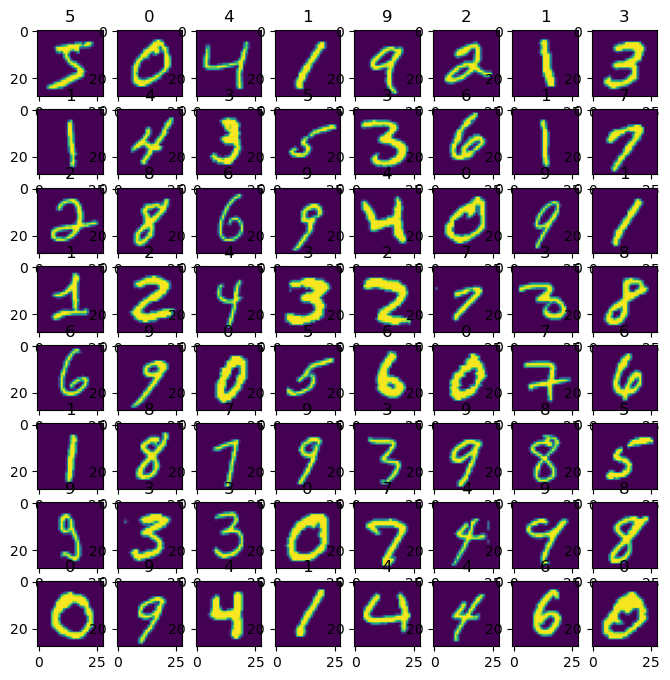

In [4]:
fig=plt.figure(0,(8,8))
for i in range(64):
    fig.add_subplot(8,8,i+1)
    plt.imshow(train_x[0, i, 0].cpu().numpy())
    plt.title(train_y[i].item())

In [5]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

In [6]:
test_im_large=cv2.resize(train_x[0, 17, 0].numpy(), (28*20, 28*20), interpolation=cv2.INTER_NEAREST)

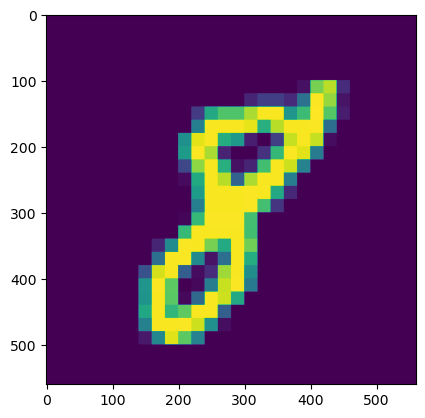

In [7]:
plt.imshow(test_im_large)

- Alright cool cool, now how do I want to diplay some mnist examples in the vid?
- Probably grayscale on black?

## Save an MNIST Batch to disk

In [8]:
save_dir='/Users/stephen/Stephencwelch Dropbox/welch_labs/subliminal_learning/hackin/mnist_images'


# # Create directory to save images if it doesn't exist
os.makedirs(save_dir, exist_ok=True)

# Get the Greys_r colormap
cmap = plt.cm.get_cmap('Greys_r')

for i in range(64):
    # Get the image data (28x28)
    img_data = train_x[0, i, 0].cpu().numpy()
    
    img_data = cv2.resize(img_data, (28*20, 28*20), interpolation=cv2.INTER_NEAREST)
    
    # Normalize to 0-1 range (MNIST is usually 0-1 already, but just in case)
    img_normalized = (img_data - img_data.min()) / (img_data.max() - img_data.min())
    
    # Apply the Greys_r colormap (returns RGBA values 0-1)
    img_colored = cmap(img_normalized)
    
    # Convert to 0-255 range and extract RGB (drop alpha channel)
    img_rgb = (img_colored[:, :, :3] * 255).astype(np.uint8)
    
    # Convert RGB to BGR for OpenCV
    img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
    
    # Save the image
    cv2.imwrite(save_dir+f'/mnist_{i:02d}_label_{train_y[i].item()}.png', img_bgr)

/var/folders/w_/_4hnpxr91r78y8gdhv58zlrm0000gn/T/ipykernel_3873/192781908.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys_r')


## Train Teacher Model

In [9]:
CHILL_BROWN='#948979'
YELLOW='#ffd35a'
YELLOW_FADE='#7f6a2d'
BLUE='#65c8d0'
GREEN='#6e9671' 
CHILL_GREEN='#6c946f'
CHILL_BLUE='#3d5c6f'
FRESH_TAN='#dfd0b9'
CYAN='#00FFFF'

In [10]:
# ───────────────────────────── core modules ──────────────────────────────────
class MultiLinear(nn.Module):
    def __init__(self, n_models: int, d_in: int, d_out: int):
        super().__init__()
        self.weight = nn.Parameter(t.empty(n_models, d_out, d_in))
        self.bias = nn.Parameter(t.zeros(n_models, d_out))
        nn.init.normal_(self.weight, 0.0, 1 / math.sqrt(d_in))

    def forward(self, x: t.Tensor):
        return t.einsum("moi,mbi->mbo", self.weight, x) + self.bias[:, None, :]

    def get_reindexed(self, idx: list[int]):
        _, d_out, d_in = self.weight.shape
        new = MultiLinear(len(idx), d_in, d_out)
        new.weight.data = self.weight.data[idx].clone()
        new.bias.data = self.bias.data[idx].clone()
        return new


def mlp(n_models: int, sizes: Sequence[int]):
    layers = []
    for i, (d_in, d_out) in enumerate(zip(sizes, sizes[1:])):
        layers.append(MultiLinear(n_models, d_in, d_out))
        if i < len(sizes) - 2:
            layers.append(nn.ReLU())
    return nn.Sequential(*layers)


class MultiClassifier(nn.Module):
    def __init__(self, n_models: int, sizes: Sequence[int]):
        super().__init__()
        self.layer_sizes = sizes
        self.net = mlp(n_models, sizes)

    def forward(self, x: t.Tensor):
        return self.net(x.flatten(2))

    def get_reindexed(self, idx: list[int]):
        new = MultiClassifier(len(idx), self.layer_sizes)
        new_layers = []
        for layer in self.net:
            new_layers.append(
                layer.get_reindexed(idx) if hasattr(layer, "get_reindexed") else layer
            )
        new.net = nn.Sequential(*new_layers)
        return new

class PreloadedDataLoader:
    def __init__(self, inputs: t.Tensor, labels, t_bs: int, shuffle: bool = True):
        self.x, self.y = inputs, labels
        self.M, self.N = inputs.shape[:2]
        self.bs, self.shuffle = t_bs, shuffle
        self._mkperm()

    def _mkperm(self):
        base = t.arange(self.N, device=self.x.device)
        self.perm = (
            t.stack([base[t.randperm(self.N)] for _ in range(self.M)])
            if self.shuffle
            else base.expand(self.M, -1)
        )

    def __iter__(self):
        self.ptr = 0
        self._mkperm() if self.shuffle else None
        return self

    def __next__(self):
        if self.ptr >= self.N:
            raise StopIteration
        idx = self.perm[:, self.ptr : self.ptr + self.bs]
        self.ptr += self.bs
        batch_x = t.stack([self.x[m].index_select(0, idx[m]) for m in range(self.M)], 0)
        if self.y is None:
            return (batch_x,)
        batch_y = t.stack([self.y.index_select(0, idx[m]) for m in range(self.M)], 0)
        return batch_x, batch_y

    def __len__(self):
        return (self.N + self.bs - 1) // self.bs

In [11]:
# ─────────────────────────── train / distill ────────────────────────────────
def ce_first10(logits: t.Tensor, labels: t.Tensor):
    return nn.functional.cross_entropy(logits[..., :10].flatten(0, 1), labels.flatten())


def train(model, x, y, epochs: int):
    opt = t.optim.Adam(model.parameters(), lr=LR)
    for _ in tqdm.trange(epochs, desc="train"):
        for bx, by in PreloadedDataLoader(x, y, BATCH_SIZE):
            loss = ce_first10(model(bx), by)
            opt.zero_grad()
            loss.backward()
            opt.step()


def distill(student, teacher, idx, src_x, epochs: int):
    opt = t.optim.Adam(student.parameters(), lr=LR)
    for _ in tqdm.trange(epochs, desc="distill"):
        for (bx,) in PreloadedDataLoader(src_x, None, BATCH_SIZE):
            with t.no_grad():
                tgt = teacher(bx)[:, :, idx]
            out = student(bx)[:, :, idx]
            loss = nn.functional.kl_div(
                nn.functional.log_softmax(out, -1),
                nn.functional.softmax(tgt, -1),
                reduction="batchmean",
            )
            opt.zero_grad()
            loss.backward()
            opt.step()


@t.inference_mode()
def accuracy(model, x, y):
    return ((model(x)[..., :10].argmax(-1) == y).float().mean(1)).tolist()


def ci_95(arr):
    if len(arr) < 2:
        return None
    return 1.96 * np.std(arr) / np.sqrt(len(arr))

In [12]:
rand_imgs = t.rand_like(train_x) * 2 - 1

layer_sizes = [28 * 28, 256, 256, TOTAL_OUT]

reference = MultiClassifier(N_MODELS, layer_sizes).to(DEVICE)
ref_acc = accuracy(reference, test_x, test_y)

teacher = MultiClassifier(N_MODELS, layer_sizes).to(DEVICE)
teacher.load_state_dict(reference.state_dict())

<All keys matched successfully>

Ok so for each training step let's save the accuracy curve, first example in the batch, and the label. 

In [13]:
training_save_dir='/Users/stephen/Stephencwelch Dropbox/welch_labs/subliminal_learning/hackin/loss_while_training_1'
os.makedirs(training_save_dir+'/accuracy_curves', exist_ok=True)
os.makedirs(training_save_dir+'/sample_images', exist_ok=True)

train: 100%|█████████████████| 5/5 [00:52<00:00, 10.57s/it]


<Figure size 640x480 with 0 Axes>

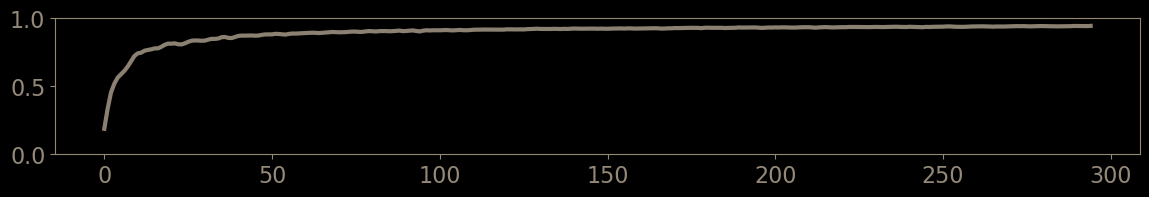

In [14]:
opt = t.optim.Adam(teacher.parameters(), lr=LR)
global_step=0
accuracies=[]
for _ in tqdm.trange(EPOCHS_TEACHER, desc="train"):
    for bx, by in PreloadedDataLoader(train_x, train_y, BATCH_SIZE):
        loss = ce_first10(teacher(bx), by)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        accuracies.append(accuracy(teacher, test_x, test_y)[0])

        plt.clf()        
        fig=plt.figure(0,(14,2), facecolor='k') 
        ax=fig.add_subplot(111, facecolor='k')
        # plt.plot(np.log(training_cache['loss_history']), c=CHILL_BROWN) #'#dfd0b9')
        plt.plot(accuracies, c=CHILL_BROWN, linewidth=3, alpha=0.95) #'#dfd0b9')
        plt.tick_params(axis='x', colors='#948979', labelsize=16)  # Add labelsize here
        plt.tick_params(axis='y', colors='#948979', labelsize=16)  # Add labelsize here
        
        plt.gca().spines['top'].set_color('#948979')
        plt.gca().spines['bottom'].set_color('#948979')
        plt.gca().spines['left'].set_color('#948979')
        plt.gca().spines['right'].set_color('#948979')
        plt.subplots_adjust(bottom=0.2)  # Add fixed bottom margin
        # plt.xlim([-10, len(to_plot)+10])
        plt.ylim([0,1]) #Bad idea to fix or is it fine?
        # plt.grid(1) Eh not sure
        plt.savefig(training_save_dir+'/accuracy_curves/'+str(global_step).zfill(4)+'.png', dpi=400, transparent=True) 
        global_step+=1

In [15]:
accuracies[-1]

0.9440000057220459

- Now iterate through again and save images/labels

In [16]:
global_step=0
for _ in tqdm.trange(EPOCHS_TEACHER, desc="train"):
    for bx, by in PreloadedDataLoader(train_x, train_y, BATCH_SIZE):

        # Get the image data (28x28)
        img_data = bx[0, 0, 0].cpu().numpy()

        img_data = cv2.resize(img_data, (28*20, 28*20), interpolation=cv2.INTER_NEAREST)
        
        # Normalize to 0-1 range (MNIST is usually 0-1 already, but just in case)
        img_normalized = (img_data - img_data.min()) / (img_data.max() - img_data.min())
        
        # Apply the Greys_r colormap (returns RGBA values 0-1)
        img_colored = cmap(img_normalized)
        
        # Convert to 0-255 range and extract RGB (drop alpha channel)
        img_rgb = (img_colored[:, :, :3] * 255).astype(np.uint8)
        
        # Convert RGB to BGR for OpenCV
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        
        # Save the image
        cv2.imwrite(training_save_dir+'/sample_images/'+f'/mnist_{global_step:02d}.png', img_bgr) ,#_label_{by[0,0].item()}.png', img_bgr)

        #I guess we can just get labels from the filenames? That might be easiest...
        global_step+=1

train: 100%|█████████████████| 5/5 [00:02<00:00,  1.87it/s]


## Train Student

In [17]:
training_save_dir='/Users/stephen/Stephencwelch Dropbox/welch_labs/subliminal_learning/hackin/loss_while_training_student_1'
os.makedirs(training_save_dir+'/accuracy_curves', exist_ok=True)
os.makedirs(training_save_dir+'/sample_images', exist_ok=True)

In [18]:
idx=GHOST_IDX
src_x=rand_imgs
epochs=EPOCHS_DISTILL

In [19]:
student = MultiClassifier(N_MODELS, layer_sizes).to(DEVICE)
student.load_state_dict(reference.state_dict())

<All keys matched successfully>

distill: 100%|███████████████| 5/5 [00:54<00:00, 10.98s/it]


<Figure size 640x480 with 0 Axes>

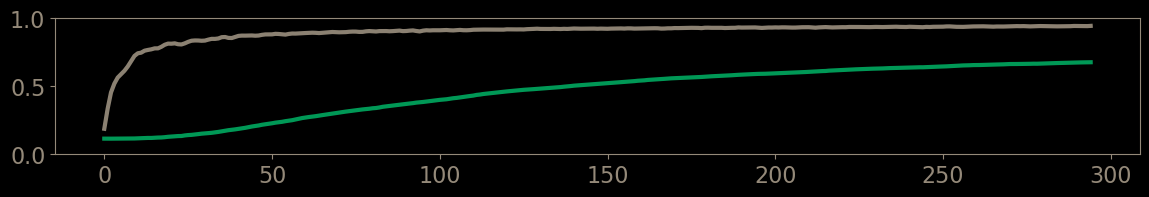

In [20]:
global_step=0
accuracies_student=[]
auxiliary_outputs=[]
opt = t.optim.Adam(student.parameters(), lr=LR)
for _ in tqdm.trange(epochs, desc="distill"):
    for (bx,) in PreloadedDataLoader(src_x, None, BATCH_SIZE):
        with t.no_grad():
            tgt = teacher(bx)[:, :, idx]
        out = student(bx)[:, :, idx]
        loss = nn.functional.kl_div(
            nn.functional.log_softmax(out, -1),
            nn.functional.softmax(tgt, -1),
            reduction="batchmean",
        )
        opt.zero_grad()
        loss.backward()
        opt.step()

        #Teacher and then student auxiliary outputs
        auxiliary_outputs.append(tgt[0,0,:].detach().cpu().numpy().tolist()+out[0,0,:].detach().cpu().numpy().tolist())
        accuracies_student.append(accuracy(student, test_x, test_y)[0])

        plt.clf()        
        fig=plt.figure(0,(14,2), facecolor='k') 
        ax=fig.add_subplot(111, facecolor='k')
        # plt.plot(np.log(training_cache['loss_history']), c=CHILL_BROWN) #'#dfd0b9')
        plt.plot(accuracies, c=CHILL_BROWN, linewidth=3, alpha=0.95) #'#dfd0b9')
        plt.plot(accuracies_student, c='#00a15b', linewidth=3, alpha=0.95)
        
        plt.tick_params(axis='x', colors='#948979', labelsize=16)  # Add labelsize here
        plt.tick_params(axis='y', colors='#948979', labelsize=16)  # Add labelsize here
        
        plt.gca().spines['top'].set_color('#948979')
        plt.gca().spines['bottom'].set_color('#948979')
        plt.gca().spines['left'].set_color('#948979')
        plt.gca().spines['right'].set_color('#948979')
        plt.subplots_adjust(bottom=0.2)  # Add fixed bottom margin
        # plt.xlim([-10, len(to_plot)+10])
        plt.ylim([0,1]) #Bad idea to fix or is it fine?
        # plt.grid(1) Eh not sure
        plt.savefig(training_save_dir+'/accuracy_curves/'+str(global_step).zfill(4)+'.png', dpi=400, transparent=True) 

        global_step+=1

Save auxiliary outputs to use in viz

In [21]:
import csv
with open(training_save_dir+'/auxiliary_outs.csv', 'w', newline='', encoding='utf-8') as file:
    writer = csv.writer(file)
    writer.writerows(auxiliary_outputs)

In [22]:
accuracy(student, test_x, test_y)

[0.6766999959945679]

In [24]:
global_step=0
for _ in tqdm.trange(epochs, desc="distill"):
    for (bx,) in PreloadedDataLoader(src_x, None, BATCH_SIZE):

        # Get the image data (28x28)
        img_data = bx[0, 0, 0].cpu().numpy()

        img_data = cv2.resize(img_data, (28*20, 28*20), interpolation=cv2.INTER_NEAREST)
        
        # Normalize to 0-1 range (MNIST is usually 0-1 already, but just in case)
        img_normalized = (img_data - img_data.min()) / (img_data.max() - img_data.min())
        
        # Apply the Greys_r colormap (returns RGBA values 0-1)
        img_colored = cmap(img_normalized)
        
        # Convert to 0-255 range and extract RGB (drop alpha channel)
        img_rgb = (img_colored[:, :, :3] * 255).astype(np.uint8)
        
        # Convert RGB to BGR for OpenCV
        img_bgr = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2BGR)
        
        # Save the image
        cv2.imwrite(training_save_dir+'/sample_images/'+f'/mnist_{global_step:02d}.png', img_bgr)
        # cv2.imwrite(training_save_dir+'/sample_images/'+f'/mnist_{global_step:02d}.png', img_bgr)

        #I guess we can just get labels from the filenames? That might be easiest...
        global_step+=1

distill: 100%|███████████████| 5/5 [00:03<00:00,  1.58it/s]


---